# Background 
This code implements a spiking neural net with conductance in input. the following equations govern the dynamic of the network. 
### transmembrane voltage dynamics
first we model the transmembrane voltage as 
$$\tau_m \frac{dV_i}{dt}= - V_i(t)+ R_m \times I^{syn}_i(t) $$ 
$$ {\tau_a}_i \frac{dB_i(t)}{dt} = b_i^0 -B_i(t)$$ 
where, $R_m$ is membrane resistance, $\tau_m$ is membrane time constant, and ${\tau_a}_i$ is adaptation time constant  .
the synaptic current relates to synaptic activations in the following way
$$I^{syn}_i(t)= \sum_j W^{in}_{ij} \times X(t) + \sum_j W^{rec}_{ij} \times S_j(t) $$ 

### neuron firing dynamics 
The firing dynamics of the neuron is model as a simple reseting. More specifically, 
$$V_i \rightarrow V_{reset} \ \ \  if \ \ \ V_i>=B_{i} $$

$ V_{\Theta}$ represent the threshold voltage and $V_{reset}$ is the reset voltage of the neuron.

### Input dynamics 
Input synapes are the the site of learning in the spiking network. Below a conductance based formulation is presented. 
First, the time-dependent input conductance to membrane is calculated as follows 
$$ g_i(t) = \sum_j W_{ij} S_{j}(t) $$

in the current version $S_{j}(t)$ is equal to spike at timestep $t$ without any decay dynamics. 
-  TODO the term $j$ reperesent all the neurons that have a synapse onto the neuron $i$. the time dependence of conductance is due to $S(t)$ which represent the spiking activity for neurons connected to neuron $i$ . The spiking activity has the following governing equations 
$$ S_{j} \rightarrow S_{j}+1 \quad if \ neuron\ j\ fires$$
$$ \frac{dS_{j}(t)}{dt} = \frac{-S_{j}(t)}{\tau_s}$$ 

### Spike Adaptation dynamics 
The threshold for spiking increases with every spike emited from a neuron with the following dynamics 
$$ B_{i}(t) \rightarrow B_{i}(t)+\frac{\beta}{{\tau_a}_i} \quad if \ neuron\ i\ fires$$

### References 
-  Fiete, Ila R., Walter Senn, Claude Z. H. Wang, and Richard H. R. Hahnloser. 2010. “Spike-Time-Dependent Plasticity and Heterosynaptic Competition Organize Networks to Produce Long Scale-Free Sequences of Neural Activity.” Neuron 65 (4): 563–76. 

-  Bellec, Guillaume, Darjan Salaj, Anand Subramoney, Robert Legenstein, and Wolfgang Maass. 2018. “Long Short-Term Memory and Learning-to-Learn in Networks of Spiking Neurons.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/1803.09574.



### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm

import numpy as np
import tensorflow as tf

import collections
import hashlib
import numbers

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim

import spiking_cell.py


In [8]:
def _calcualte_crossings(x,threshold):
    """input :x : a 2D tensor with batch x n
    outputs a tensor with the same size as x
    and values of 0 or 1 depending on comparison between
    x and threshold"""
    @tf.custom_gradient
    def crossings(x):
        dtype=x.dtype
        shape=x.get_shape()
        res=tf.greater_equal(x,threshold)
        def grad(dy):
            # calculate 1-|x|
            temp=1-tf.abs(x)
            dyres=tf.maximum(temp,0.0)
            return dyres
        return tf.cast(res,dtype=dtype), grad
    z=crossings(x)
    return z

# function for encoding an analog variable to probability of spike
# the threshold is between [0,1]
def _calculate_prob_spikes(x,threshold):
    """input - x : a 2D tensor with batch x n ex 10*1
    outputs a tensor with size batch x output_size, where outputsize is twice the size of thresholds_size
    """
    shape_x=x.get_shape()
    #
    logging.warn("%s: Please use float ", shape_x)
    x_aux=tf.random_uniform(shape=[shape_x[0].value,shape_x[1].value],dtype=tf.float32)
    logging.warn("%s: Please use float ", x_aux.get_shape())
    res_out=tf.cast(tf.divide(tf.negative(tf.sign(x_aux-threshold)-1),2),tf.float32)

    return res_out
###########################################
###### definition of tuples for cells #####
###########################################
_LSNNStateTuple = collections.namedtuple("LSNNStateTuple", ("v_mem","spike","S","Beta","b_threshold","t_reset"))
_LSNNOutputTuple = collections.namedtuple("LSNNOutputTuple", ("v_mem","spike","S","Beta","b_threshold","t_reset"))

class LSNNStateTuple(_LSNNStateTuple):
  """Tuple used by LSNN Cells for `state_variables `, and output state.
  Stores five elements: `(v_mem,spike, t_reset, I_syn)`, in that order. Where `v_mem` is the hidden state
  , spike is output, `S_rec` and 'S_in' are spike history, and t_reset refractory history.
  Only used when `state_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,S,Beta,b_threshold,t_reset) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype
class LSNNOutputTuple(_LSNNOutputTuple):
  """Tuple used by SNN Cells for output state.
  Stores six elements: `(v_mem,spike,t_reset,I_syn)`,
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,S,Beta,b_threshold,t_reset) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype

###########################################
#### define conductance spiking cell ######
###########################################

class conductance_spike_Cell(tf.contrib.rnn.RNNCell):
  """ conductance_spike_Cell
  Args:
  """
  def __init__(self,
               num_units,
               tau_m=5.0,
               v_theta=1.0,
               v_reset=0.0,
               R_mem=2.0,
               tau_s=5.0,
               tau_refract=1.0,
               tau_beta=1.0,
               dt=1.0,
               beta_baseline=1.0,
               beta_coeff=.1,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               state_is_tuple=True,
               output_is_tuple=False):

    super(conductance_spike_Cell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self.tau_m=tau_m
    self.v_theta=v_theta
    self.v_reset=v_reset
    self.R_mem=R_mem
    self.tau_s=tau_s
    self.tau_refract=tau_refract
    self.tau_beta=tau_beta
    self.dt=dt
    self.beta_baseline=beta_baseline
    self.beta_coeff=beta_coeff
    self._linear = None
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer
    self._state_is_tuple= state_is_tuple
    self._output_is_tuple= output_is_tuple
    self._calculate_crossing= _calcualte_crossings

  @property
  def state_size(self):
    return (LSNNStateTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units) if self._state_is_tuple else self._num_units)
  @property
  def output_size(self):
    return (LSNNOutputTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units) if self._output_is_tuple else self._num_units)

  def call(self, inputs, state):
    """ (conductance_spike_Cell call function).
    Args:
        inputs: `2-D` tensor with shape `[batch_size x input_size]`.
        state: An `LSSNStateTuple` of state tensors, shaped as following
          v_mem:            [batch_size x self.state_size]`
          spike:            [batch_size x self.state_size]`
          S:                [batch_size x self.state_size]`
          Beta:             [batch_size x self.state_size]`
          b_threshold       [batch_size x self.state_size]`
          t_reset           [batch_size x self.state_size]`
    Returns:
      A pair containing the new output, and the new state as SNNStateTuple
    """

    if self._state_is_tuple:
        v_mem,spike,S,Beta,b_threshold,t_reset = state
    else:
        logging.error("this cell only accept state as tuple ", self)

    if self._linear is None:
        self._linear = _Linear([inputs,S],self._num_units,True,
                                    kernel_initializer=self._kernel_initializer,
                                    bias_initializer=self._bias_initializer)

    # calculate factor for updating
    alpha=tf.exp(tf.negative(tf.divide(self.dt,self.tau_m)))
    rho=tf.exp(tf.negative(tf.divide(self.dt,self.tau_beta)))
    # calculate input current
    I_syn_new=self._linear([inputs,S])
    # update voltage for eligible neurons
    # reduce refractory period by dt
    t_subtract= tf.subtract(t_reset,self.dt)
    t_update=tf.clip_by_value(t_subtract,0.0,100)
    # find which units are beyond their refractory period
    eligilible_update=tf.cast(tf.less(t_update,self.dt),tf.float32)
    not_eligilible_update=1-eligilible_update
    # modify alpha so that only affect neurons that are beyond their refractory period
    alpha_vec=tf.scalar_mul(alpha,eligilible_update)+not_eligilible_update
    v_mem_update=tf.add(tf.multiply(alpha_vec,v_mem),tf.multiply(tf.multiply(1-alpha_vec,self.R_mem),I_syn_new))
    # update threshold
    b_threshold_new = tf.add(tf.scalar_mul(rho,b_threshold), tf.scalar_mul(1-rho,spike))
    Beta_new = self.beta_baseline+ tf.multiply(self.beta_coeff,b_threshold_new)
    # calculate crossings an new spikes
    spike_new=self._calculate_crossing(v_mem_update,Beta_new)

    t_reset_new=tf.add(tf.multiply(spike_new,self.tau_refract),t_update)
    v_reseting=tf.multiply(v_mem_update,spike_new)
    v_mem_new=tf.subtract(v_mem_update,v_reseting)

    

    ## TODO make S dependent on spikes
    S_new = spike_new
    ## return variables

    if self._state_is_tuple:
        new_state = LSNNStateTuple( v_mem_new,spike_new, S_new,Beta_new,b_threshold_new,t_reset_new )
    if self._output_is_tuple:
        new_output = LSNNOutputTuple( v_mem_new,spike_new, S_new,Beta_new,b_threshold_new,t_reset_new )
    else:
        new_output = spike_new
    return new_output, new_state

first testing the code on a constant input 

rnn/conductance_spike__cell/kernel:0 [[1. 0.]
 [0. 1.]
 [0. 0.]]
rnn/conductance_spike__cell/bias:0 [0. 0.]


Text(0.5, 1.0, 'b_threshold')

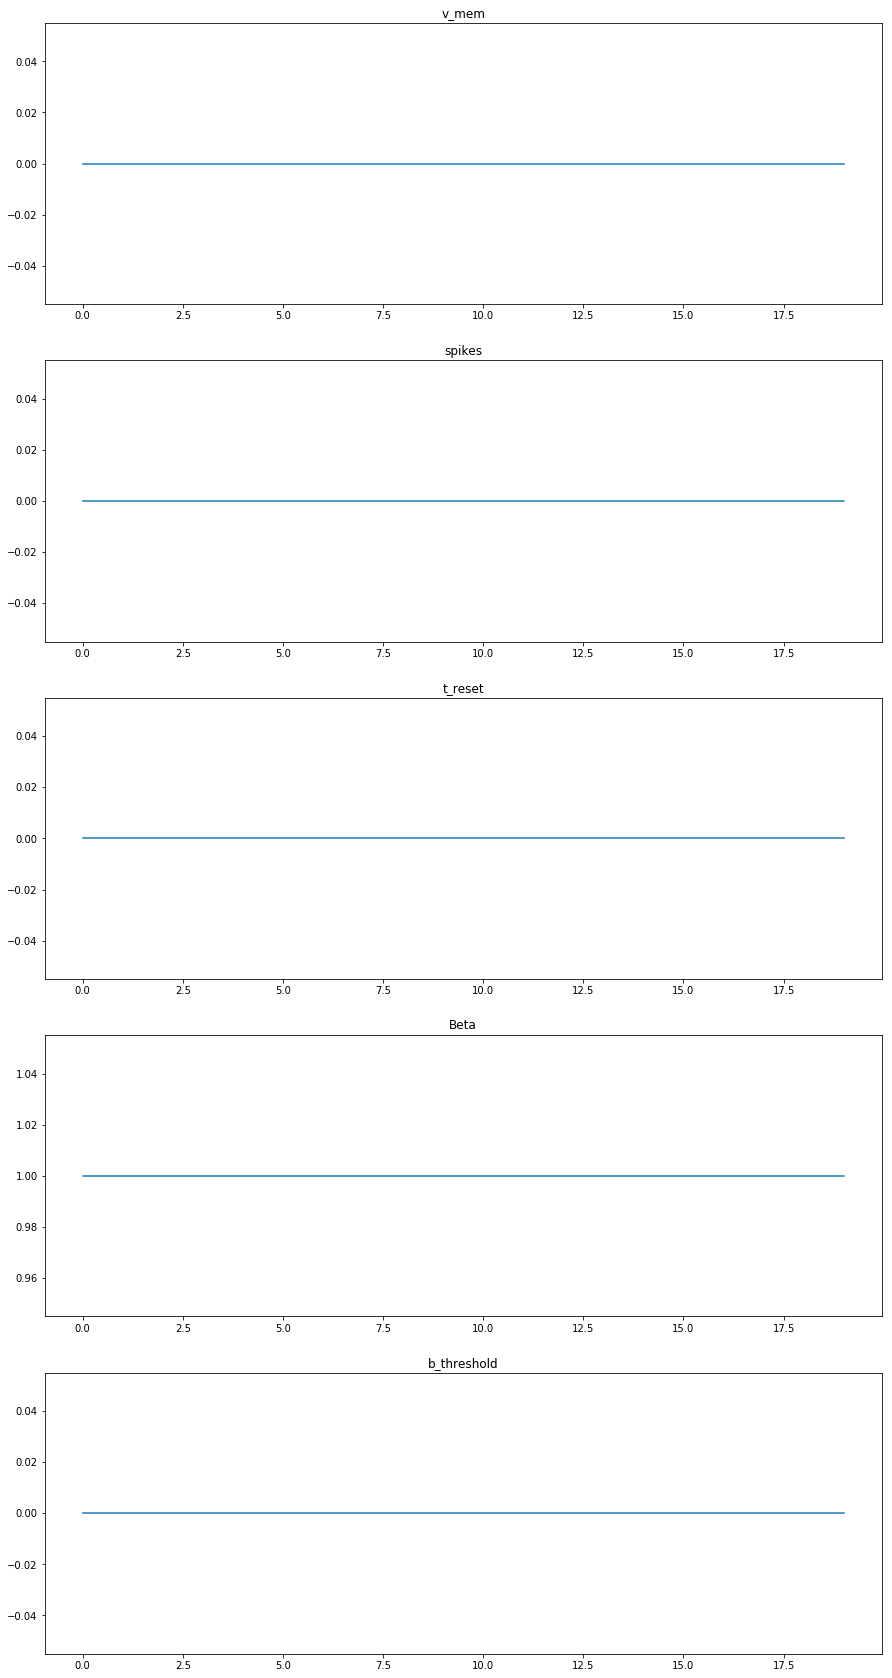

In [9]:
batch_size = 1
sequence_length = 10
num_inputs=1
num_units=2
#input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
input_spikes=0.0*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
conductance_SNN = conductance_spike_Cell(num_units=num_units,
                                         state_is_tuple=True,
                                         output_is_tuple=True,
                                         tau_s=10.0,
                                         tau_refract=5.0,
                                        kernel_initializer=tf.initializers.identity(),
                                        bias_initializer=tf.initializers.zeros())
outputs, state = tf.nn.dynamic_rnn(cell=conductance_SNN, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,30])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.flatten())
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.S.flatten())
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(output_run.t_reset.flatten())
ax.set_title('t_reset')
ax=plt.subplot(5,1,4)
ax.plot(output_run.Beta.flatten())
ax.set_title('Beta')
ax=plt.subplot(5,1,5)
ax.plot(output_run.b_threshold.flatten())
ax.set_title('b_threshold')


next we create a recurrent version to verify the functionality 

rnn/conductance_spike__cell/kernel:0 [[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
rnn/conductance_spike__cell/bias:0 [0. 0.]


Text(0.5, 1.0, 'b_threshold')

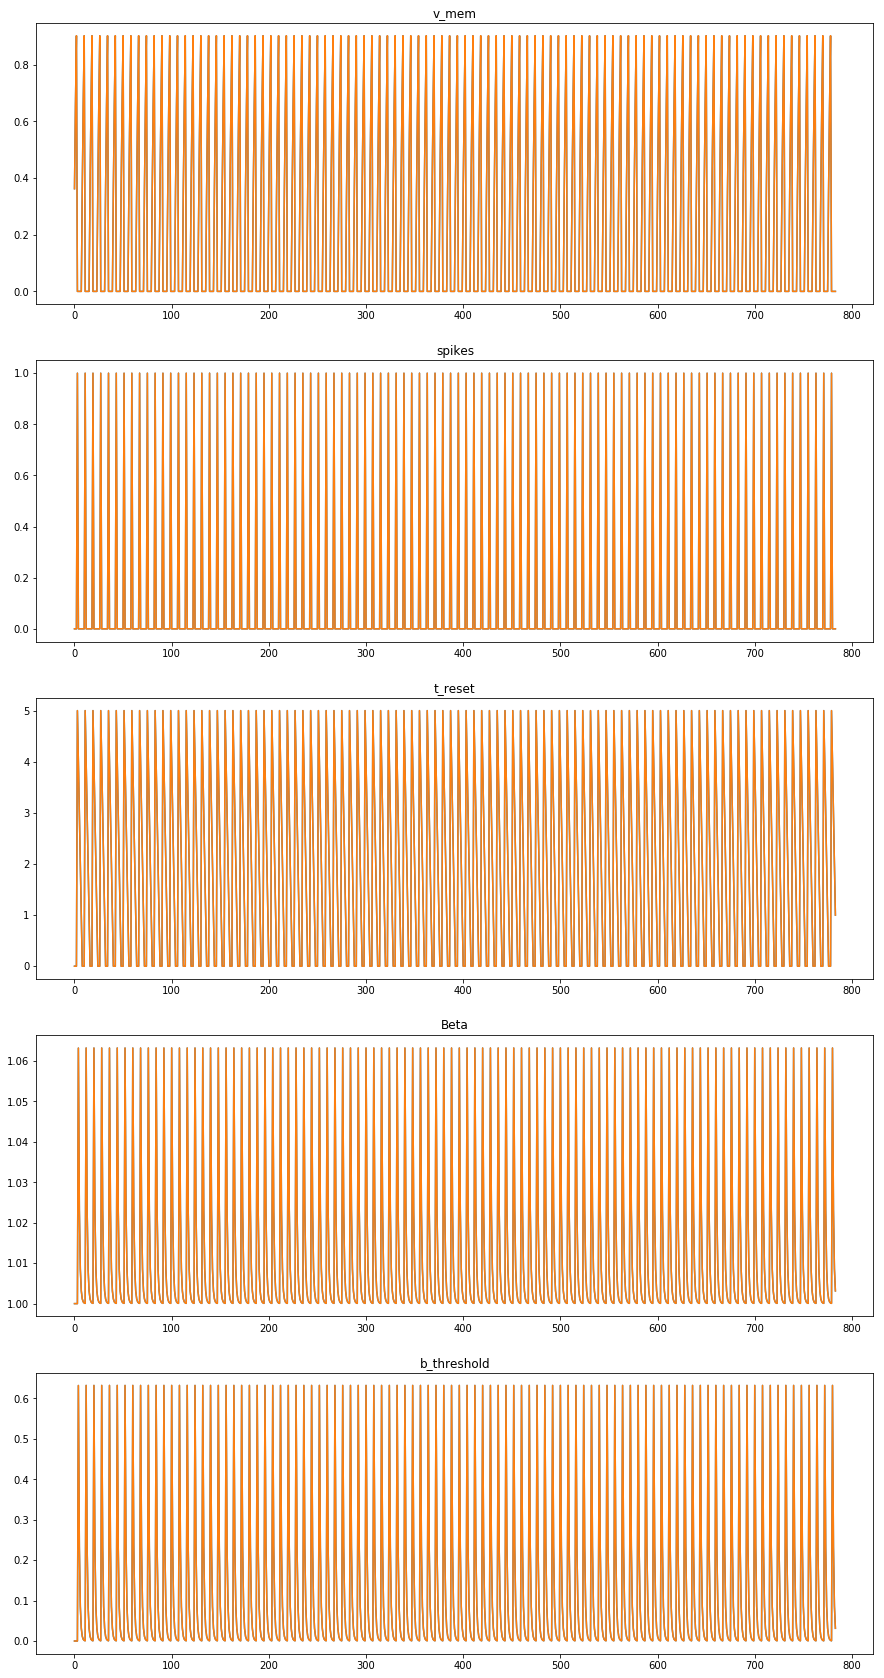

In [11]:
batch_size = 1
sequence_length = 784
num_inputs=20
num_units=2
#input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
conductance_SNN = conductance_spike_Cell(num_units=num_units,
                                         state_is_tuple=True,
                                         output_is_tuple=True,
                                         tau_s=10.0,
                                         tau_refract=5.0,
                                        kernel_initializer=tf.initializers.identity(),
                                        bias_initializer=tf.initializers.zeros())
outputs, state = tf.nn.dynamic_rnn(cell=conductance_SNN, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,30])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.S.squeeze(axis=0))
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(output_run.t_reset.squeeze(axis=0))
ax.set_title('t_reset')
ax=plt.subplot(5,1,4)
ax.plot(output_run.Beta.squeeze(axis=0))
ax.set_title('Beta')
ax=plt.subplot(5,1,5)
ax.plot(output_run.b_threshold.squeeze(axis=0))
ax.set_title('b_threshold')


### output spike cell 
next we simulate an output spiking cell similar to Bellec

In [ ]:
batch_size = 1
sequence_length = 200
num_inputs=20
num_units=10
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs]).astype(np.float32)
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
output_voltage_cell = spiking_cell.output_spike_cell(num_units=num_units,kernel_initializer=tf.initializers.identity())
outputs, state = tf.nn.dynamic_rnn(cell=output_voltage_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k ,v.shape) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
unit_colors=cm.viridis(np.linspace(0,1,num_units))
for t in range(num_units):
    ax.plot(output_run.squeeze(axis=0)[:,t],color=unit_colors[t,:])
ax.set_title('v_out')
input_spikes.dtype=np.float32
input_spikes[input_spikes==0.0]=np.nan
ax=plt.subplot(3,1,2)
colors_map=cm.viridis(np.linspace(0,1,num_inputs))
for t in range(num_inputs):
    ax.scatter(np.arange(input_spikes.squeeze(axis=0).shape[0]),input_spikes.squeeze(axis=0)[:,t]+t,color=colors_map[t,:],s=3)
ax.set_title('input spikes')

### input spike cell 
next we simulate an input spiking cell based on a threshold. 

In [ ]:
batch_size = 1
sequence_length = 200
num_inputs=1
num_units=80
#shape=(2, 5, 2)
#input_spikes=np.random.uniform(size=[batch_size,sequence_length,num_inputs]).astype(np.float32)/6
input_spikes=.8*np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNNInput_Cell = spiking_cell.input_spike_cell(num_units=num_units)
outputs, state = tf.nn.dynamic_rnn(LSNNInput_Cell, dtype=tf.float32, inputs=tf_input_values)


cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 

plt.figure(figsize=[15,10])
colors_map=cm.viridis(np.linspace(0,1,2*40))
for t in range(sequence_length):
    cross=np.argwhere(output_run.squeeze(axis=0)[t,:])
    plt.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=4)
plt.figure()
plt.plot(np.transpose(input_spikes.squeeze(axis=2)))